In [1]:
import math
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.ticker import ScalarFormatter
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import chaosmagpy as cp

In [9]:
def dx(ym, xm, f):
    dxm = np.abs(xm[0, 1] - xm[0, 0])
    der = (np.roll(f, -1, axis=1) - np.roll(f, 1, axis=1)) / (2 * dxm)
    der[:, 0] = (f[:, 1] - f[:, -2]) / (2 * dxm)
    der[:, -1] = der[:, 0]
    return der

def dy(ym, xm, f):
    dym = np.abs(ym[1, 0] - ym[0, 0])
    der = (np.roll(f, -1, axis=0) - np.roll(f, 1, axis=0)) / (2 * dym)
    der[0, :] = (f[1, :] - f[0, :]) / dym
    der[1, :] = (f[-1, :] - f[-2, :]) / dym
    return der

def ddy(ym, xm, f):
    dym = np.abs(ym[1, 0] - ym[0, 0])
    der = (np.roll(f, 1, axis=0) - 2 * f + np.roll(f, -1, axis=0)) / (dym ** 2)
    der[0, :] = der[1, :]
    der[-1, :] = der[-2, :]
    return der

def ddx(ym, xm, f):
    dxm = np.abs(xm[0, 1] - xm[0, 0])
    der = (np.roll(f, 1, axis=1) - 2 * f + np.roll(f, -1, axis=1)) / (dxm ** 2)
    der[:, 0] = (f[:, 1] - 2 * f[:, 0] + f[:, -2]) / (dxm ** 2)
    der[:, -1] = der[:, 0]
    return der

def ddxy(ym, xm, f):
    df_dx = dx(ym, xm, f)
    ddf_dxy = dy(ym, xm, df_dx)
    return ddf_dxy

def detH(ddx, ddy, ddxy):
    # Hessian determinant simplified as product of second derivatives
    derH = ddx * ddy
    return derH

def K(dx, dy, ddx, ddy, ddxy):
    # Calculate Gaussian curvature
    up = (dx * ddxy * dy) + (ddxy * dy * dx) - (dx * ddy * dx) - (ddx * dy * dy)
    down = ((dx ** 2) + (dy ** 2)) ** 2
    cur = -up / down
    return cur

def mean_F(f, thetam):
    # Compute mean value of f weighted by sin(theta)
    theta_rad = np.deg2rad(thetam)
    sin_theta = np.sin(theta_rad)
    product_sum = np.sum(f[30:151, :] * sin_theta[30:151, :])
    C = np.sum(sin_theta[30:151, :])
    mean = product_sum / C
    return mean

def calculate_integral(B):
    # Calculate normalized integral over specified lat-lon regions
    phi_range = np.linspace(0, 2 * np.pi, B.shape[1] + 1)
    theta_range = np.linspace(0, np.pi, B.shape[0] + 1)

    integrals = [0, 0]
    theta_min = np.deg2rad(25)
    theta_max = np.deg2rad(155)
    region_boundaries = [
        [(0, 2 * np.pi), (0, theta_min)],
        [(0, 2 * np.pi), (theta_max, np.pi)]
    ]

    for i, region in enumerate(region_boundaries):
        for j in range(len(phi_range) - 1):
            for k in range(len(theta_range) - 1):
                phi_lower = phi_range[j]
                phi_upper = phi_range[j + 1]
                theta_lower = theta_range[k]
                theta_upper = theta_range[k + 1]
                sin_theta = np.sin((theta_lower + theta_upper) / 2)
                d_phi = phi_upper - phi_lower
                d_theta = theta_upper - theta_lower

                # Check if cell is inside region
                if region[0][0] <= (phi_lower + phi_upper) / 2 <= region[0][1] and \
                   region[1][0] <= (theta_lower + theta_upper) / 2 <= region[1][1]:
                    integrals[i] += B[k, j] * sin_theta * d_phi * d_theta

    integral = sum(integrals)
    return integral

def F_boundary(constant, B, B_t0):
    # Compute boundary F
    Fup = calculate_integral(B)
    Fdown = calculate_integral(B_t0)
    F_out = Fup / Fdown
    boundaryF = constant * F_out
    return boundaryF

def detH_saddle(DETH, thetam, phim, crossingsX, crossingsY):
    # Separate saddle and extrema points using interpolated DETH
    lat_grid = thetam[:, 0]
    lon_grid = phim[0, :]
    interp_func = scipy.interpolate.RegularGridInterpolator(
        (lat_grid, lon_grid),
        DETH,
        bounds_error=False,
        fill_value=np.nan
    )

    cross = np.column_stack((crossingsX, crossingsY))
    points_for_interp = cross[:, [1, 0]]

    # Interpolate values
    values = interp_func(points_for_interp)

    # Classify positive and negative points
    pos_mask = values > 0
    neg_mask = values <= 0
    pos_points = points_for_interp[pos_mask]
    neg_points = points_for_interp[neg_mask]

    return pos_points, neg_points

def F_C_ObO(x, y, fun1, fun2, lev):
    c_fx = plt.contour(x, y, fun1, levels=[lev])
    c_fy = plt.contour(x, y, fun2, levels=[lev])

    Line_dx = []
    points_dx = []
    paths = c_fx.get_paths()
    polygons = paths[0].to_polygons()

    for i, poly in enumerate(polygons):
        verts = poly
        if abs(verts[-1, 0] - verts[-2, 0]) > 10 or abs(verts[-1, 1] - verts[-2, 1]) > 10:
            zz = 2
        else:
            zz = 1
        points_dx.extend(verts)
        FxLine = []

        for v in range(len(verts) - zz):
            xa, ya = verts[v]
            xb, yb = verts[v + 1]
            xlist = np.array([xa, xb])
            ylist = np.array([ya, yb])

            # Skip if two points are too close (to avoid polyfit failure)
            if np.isclose(xa, xb) and np.isclose(ya, yb):
                continue

            try:
                k, b = np.polyfit([xa, xb], [ya, yb], deg=1)
            except np.linalg.LinAlgError:
                print(f"Warning: polyfit failed for points ({xa}, {ya}) - ({xb}, {yb}), skipped.")
                continue

            k, b = np.polyfit(xlist, ylist, deg=1)
            FxLine.append([k, b, xa, xb, ya, yb])

        Line_dx.append(np.array(FxLine))

    Line_dy = []
    points_dy = []
    paths = c_fy.get_paths()
    polygons = paths[0].to_polygons()

    for i, poly in enumerate(polygons):
        verts = poly
        if abs(verts[-1, 0] - verts[-2, 0]) > 10 or abs(verts[-1, 1] - verts[-2, 1]) > 10:
            zz = 2
        else:
            zz = 1
        points_dy.extend(verts)
        FyLine = []

        for v in range(len(verts) - zz):
            xa, ya = verts[v]
            xb, yb = verts[v + 1]
            xlist = np.array([xa, xb])
            ylist = np.array([ya, yb])

            # Skip if two points are too close (to avoid polyfit failure)
            if np.isclose(xa, xb) and np.isclose(ya, yb):
                continue

            try:
                k, b = np.polyfit([xa, xb], [ya, yb], deg=1)
            except np.linalg.LinAlgError:
                print(f"Warning: polyfit failed for points ({xa}, {ya}) - ({xb}, {yb}), skipped.")
                continue

            k, b = np.polyfit(xlist, ylist, deg=1)
            FyLine.append([k, b, xa, xb, ya, yb])

        Line_dy.append(np.array(FyLine))

    x_cross = []
    y_cross = []

    for n in range(len(Line_dx)):
        Fx = Line_dx[n]
        for m in range(len(Line_dy)):
            Fy = Line_dy[m]
            for p in range(len(Fx[:, 0])):
                k1, b1, x1, x2, y1, y2 = Fx[p, :]
                for q in range(len(Fy[:, 0])):
                    k2, b2, x3, x4, y3, y4 = Fy[q, :]
                    x_c = (b2 - b1) / (k1 - k2)
                    if x_c is not None:
                        # Check if x_c is within the x-range of both line segments
                        in_range_1 = (min(x1, x2) <= x_c <= max(x1, x2))
                        in_range_2 = (min(x3, x4) <= x_c <= max(x3, x4))
                        if in_range_1 and in_range_2:
                            y_c = k1 * x_c + b1
                            if y_c is not None:
                                # Check if y_c is within the y-range of both line segments
                                in_range_3 = (min(y1, y2) <= y_c <= max(y1, y2))
                                in_range_4 = (min(y3, y4) <= y_c <= max(y3, y4))
                                if in_range_3 and in_range_4:
                                    x_cross.append(x_c)
                                    y_cross.append(y_c)

    x_cross = np.array(x_cross)
    y_cross = np.array(y_cross)

    # Keep only points with y in [5, 175]
    mask = (y_cross >= 5) & (y_cross <= 175)
    x_cross = x_cross[mask]
    y_cross = y_cross[mask]

    return x_cross, y_cross


def detH_saddle(DETH, thetam, phim, crossingsX, crossingsY):
    lat_grid = thetam[:, 0]
    lon_grid = phim[0, :]
    interp_func = scipy.interpolate.RegularGridInterpolator((lat_grid, lon_grid), DETH, bounds_error=False, fill_value=np.nan)

    cross = np.column_stack((crossingsX, crossingsY))
    cross = np.array(cross)
    points_for_interp = cross[:, [1, 0]]

    # Interpolate DETH values at crossing points
    values = interp_func(points_for_interp)

    # Separate points based on sign of interpolated DETH
    pos_mask = values > 0
    neg_mask = values <= 0
    pos_points = points_for_interp[pos_mask]
    neg_points = points_for_interp[neg_mask]

    return pos_points, neg_points


In [11]:
# Compute main magnetic field at grid points
def magnetic_point(gsh, hsh, lmax, r, lats, lons):
    a = 6371.2
    pi = math.pi
    # lons2d and lats2d are assumed to be 2D arrays of coordinates
    lons2d, lats2d = lons, lats
    phi = lons2d
    cost2d = np.cos((lats2d) * np.pi / 180)
    i = 0
    br = np.zeros(cost2d.shape)
    bphi = np.zeros(cost2d.shape)
    btheta = np.zeros(cost2d.shape)
    
    for l in np.arange(1, lmax + 1, 1):
        for m in np.arange(0, l + 1, 1):
            g = gsh[i]
            h = hsh[i]
            # Calculate Schmidt quasi-normalization factor
            if m == 0:
                schmidt = 1.0
            else:
                schmidt = ((-1.0) ** m) * np.sqrt(2.0 * math.factorial(l - m) / math.factorial(l + m))
            lagendre = scipy.special.lpmv(m, l, cost2d)
            lagendre_ = scipy.special.lpmv(m, l - 1, cost2d)
            div_lagendre = (l * cost2d * lagendre - (l + m) * lagendre_) / np.sqrt(1 - cost2d ** 2)
            br = br + schmidt * (float(l) + 1.0) * ((a / r) ** (l + 2)) * lagendre * (
                        g * np.cos(float(m) * phi * pi / 180.0) + h * np.sin(float(m) * phi * pi / 180.0))
            bphi = bphi + schmidt * (m / np.sin((lats2d) * pi / 180)) * ((a / r) ** (l + 2)) * lagendre * (
                        -g * np.sin(float(m) * phi * pi / 180.0) + h * np.cos(float(m) * phi * pi / 180.0))
            btheta = btheta + schmidt * ((a / r) ** (l + 2)) * div_lagendre * (
                        g * np.cos(float(m) * phi * pi / 180.0) + h * np.sin(float(m) * phi * pi / 180.0))
            i += 1
    return br, bphi, btheta, lons2d, lats2d


# Compute magnetic intensity at specific points
def magnetic_point(gsh, hsh, lmax, r, y, x):
    fi = []
    for i in range(len(y)):
        br, bphi, btheta, _, _ = magnetic_field(gsh, hsh, lmax, radius, y[i], x[i])
        fff = np.sqrt(br**2 + bphi**2 + btheta**2) / 1000
        fi.append(fff)
    return np.array(fi).squeeze()


In [7]:
radius = 6371.
theta = np.linspace(1., 179., num=181)  # colatitude in degrees
phi = np.linspace(0., 360., num=361)  # longitude in degrees
phim, thetam = np.meshgrid(phi, theta)
radiusm = radius * np.ones(phim.shape)
model = cp.load_CHAOS_matfile('D:\Fig\origin data\coeff\CHAOS-8.2.mat')

time = cp.data_utils.mjd2000(2020, 1, 1)  # modified Julian date
B_radius_2020, B_theta_2020, B_phi_2020 = model.synth_values_tdep(time, radiusm, thetam, phim)
F2020 = np.sqrt(B_radius_2020 ** 2 + B_theta_2020 ** 2 + B_phi_2020 ** 2) / 1000
Fo2020=calculate_integral(F2020)

6
yr= 2000
6
yr= 2001
6
yr= 2002


D:\Anaconda\envs\Saddle\Lib\site-packages\numpy\lib\_polynomial_impl.py:674: RuntimeWarning: invalid value encountered in divide
  lhs /= scale


6
yr= 2003


D:\Anaconda\envs\Saddle\Lib\site-packages\numpy\lib\_polynomial_impl.py:674: RuntimeWarning: invalid value encountered in divide
  lhs /= scale


6
yr= 2004


D:\Anaconda\envs\Saddle\Lib\site-packages\numpy\lib\_polynomial_impl.py:674: RuntimeWarning: invalid value encountered in divide
  lhs /= scale


6
yr= 2005


D:\Anaconda\envs\Saddle\Lib\site-packages\numpy\lib\_polynomial_impl.py:674: RuntimeWarning: invalid value encountered in divide
  lhs /= scale


6
yr= 2006


D:\Anaconda\envs\Saddle\Lib\site-packages\numpy\lib\_polynomial_impl.py:674: RuntimeWarning: invalid value encountered in divide
  lhs /= scale


6
yr= 2007


D:\Anaconda\envs\Saddle\Lib\site-packages\numpy\lib\_polynomial_impl.py:674: RuntimeWarning: invalid value encountered in divide
  lhs /= scale


8
yr= 2008
8
yr= 2009
8
yr= 2010
8
yr= 2011
8
yr= 2012
8
yr= 2013
8
yr= 2014
8
yr= 2015


D:\Anaconda\envs\Saddle\Lib\site-packages\numpy\lib\_polynomial_impl.py:674: RuntimeWarning: invalid value encountered in divide
  lhs /= scale


8
yr= 2016


D:\Anaconda\envs\Saddle\Lib\site-packages\numpy\lib\_polynomial_impl.py:674: RuntimeWarning: invalid value encountered in divide
  lhs /= scale


8
yr= 2017


D:\Anaconda\envs\Saddle\Lib\site-packages\numpy\lib\_polynomial_impl.py:674: RuntimeWarning: invalid value encountered in divide
  lhs /= scale


8
yr= 2018


D:\Anaconda\envs\Saddle\Lib\site-packages\numpy\lib\_polynomial_impl.py:674: RuntimeWarning: invalid value encountered in divide
  lhs /= scale


8


C:\Users\yue-y\AppData\Local\Temp\ipykernel_28428\1976002872.py:67: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(8, 6))


yr= 2019


D:\Anaconda\envs\Saddle\Lib\site-packages\numpy\lib\_polynomial_impl.py:674: RuntimeWarning: invalid value encountered in divide
  lhs /= scale


8
yr= 2020


D:\Anaconda\envs\Saddle\Lib\site-packages\numpy\lib\_polynomial_impl.py:674: RuntimeWarning: invalid value encountered in divide
  lhs /= scale


8
yr= 2021


D:\Anaconda\envs\Saddle\Lib\site-packages\numpy\lib\_polynomial_impl.py:674: RuntimeWarning: invalid value encountered in divide
  lhs /= scale


8
yr= 2022


D:\Anaconda\envs\Saddle\Lib\site-packages\numpy\lib\_polynomial_impl.py:674: RuntimeWarning: invalid value encountered in divide
  lhs /= scale


8
yr= 2023


D:\Anaconda\envs\Saddle\Lib\site-packages\numpy\lib\_polynomial_impl.py:674: RuntimeWarning: invalid value encountered in divide
  lhs /= scale
C:\Users\yue-y\AppData\Local\Temp\ipykernel_28428\3669139330.py:184: RankWarning: Polyfit may be poorly conditioned
  k, b = np.polyfit([xa, xb], [ya, yb], deg=1)
C:\Users\yue-y\AppData\Local\Temp\ipykernel_28428\3669139330.py:189: RankWarning: Polyfit may be poorly conditioned
  k, b = np.polyfit(xlist, ylist, deg=1)


8
yr= 2024


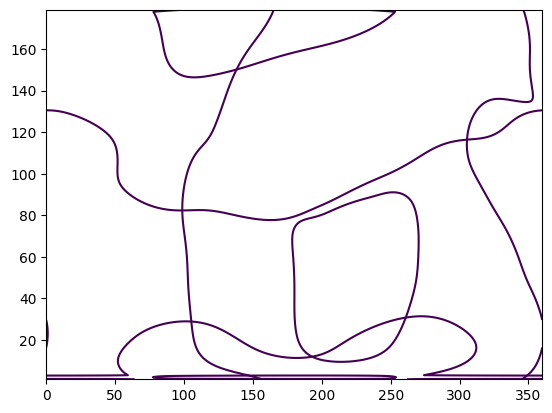

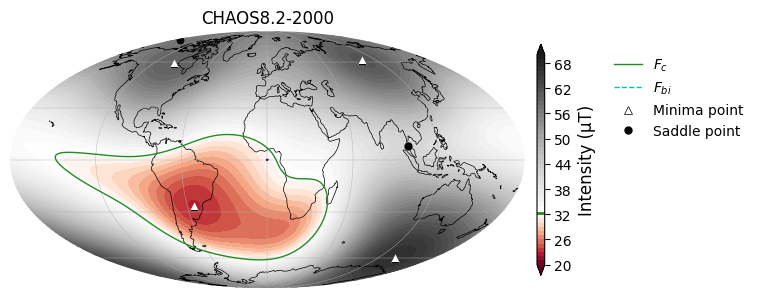

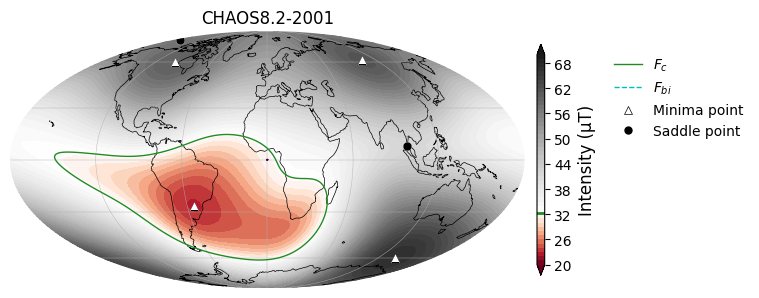

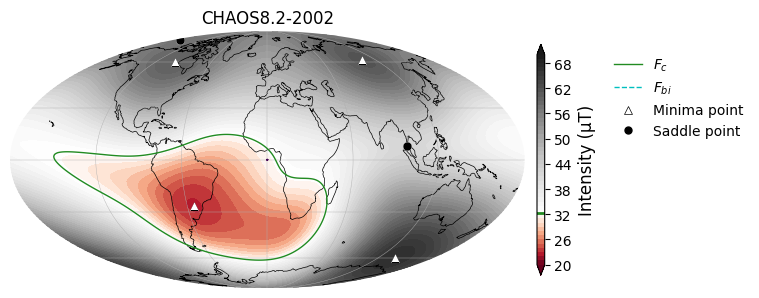

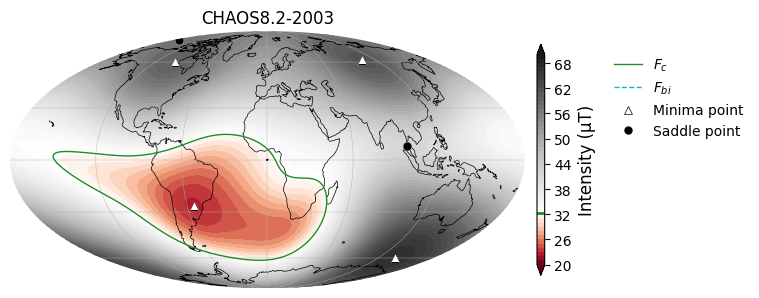

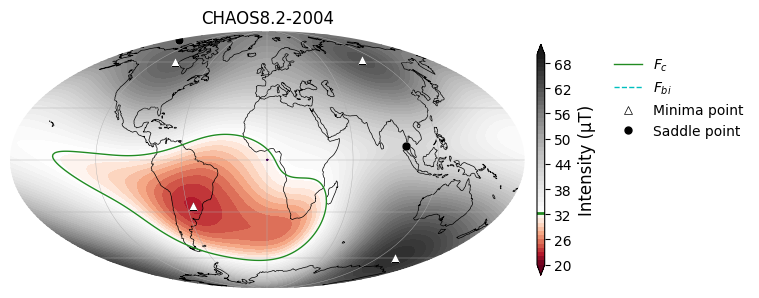

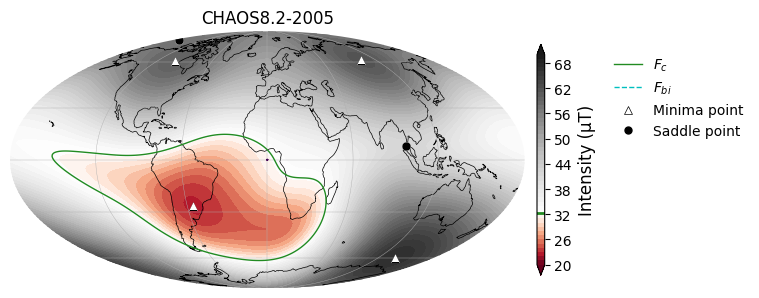

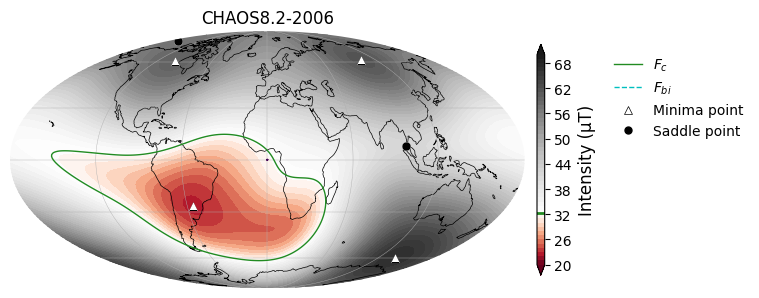

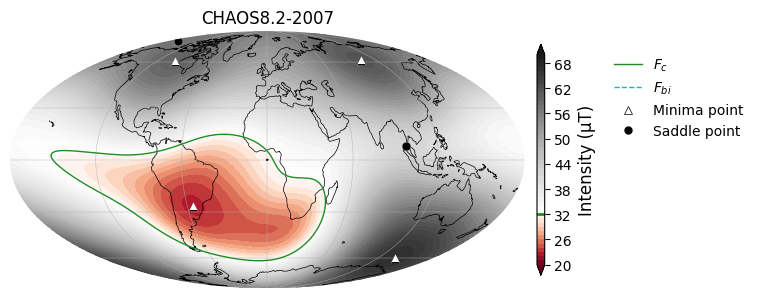

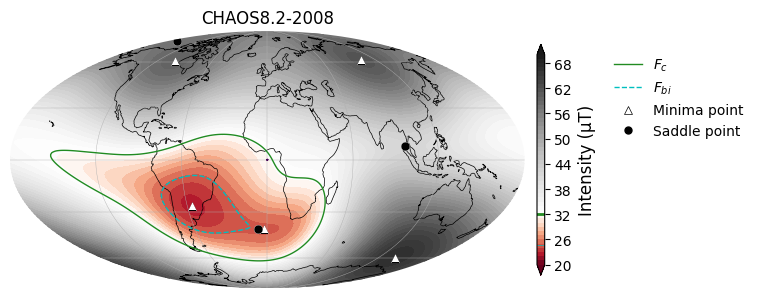

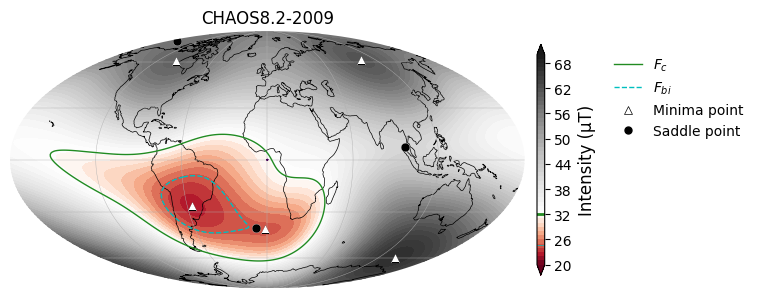

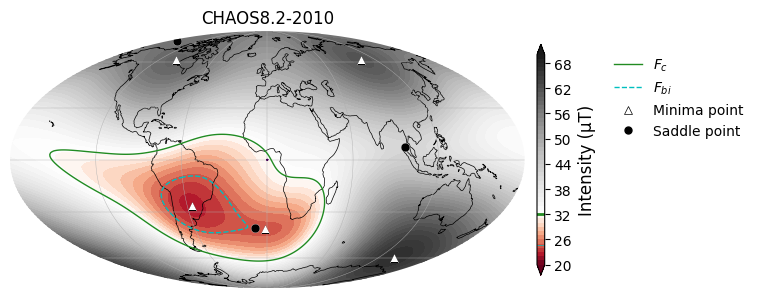

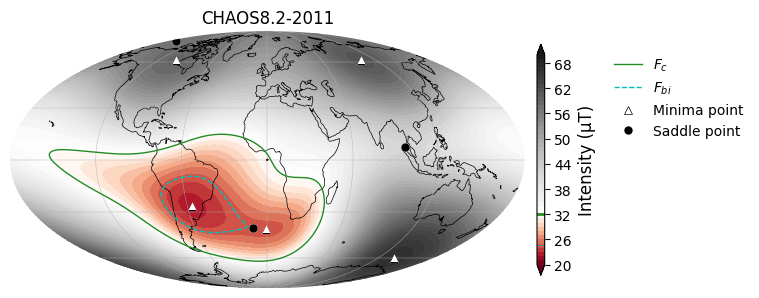

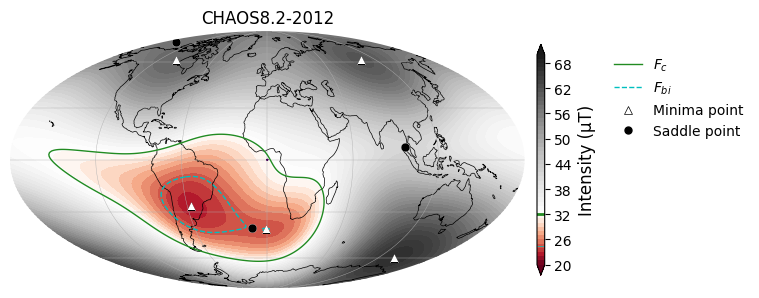

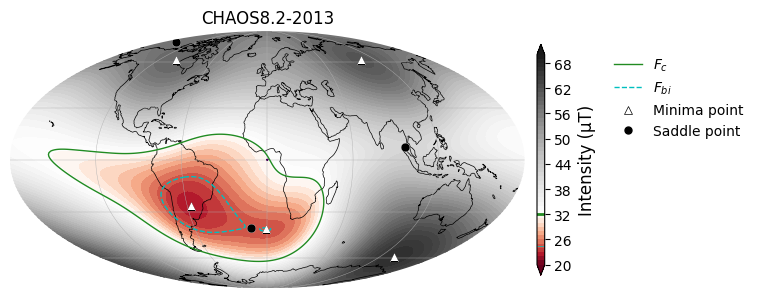

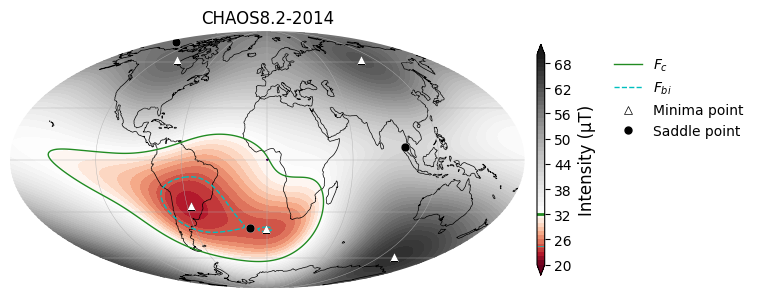

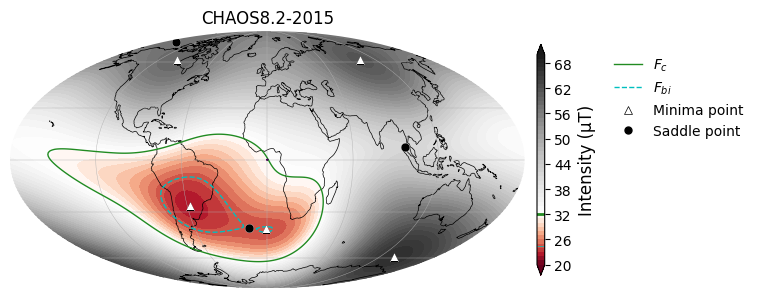

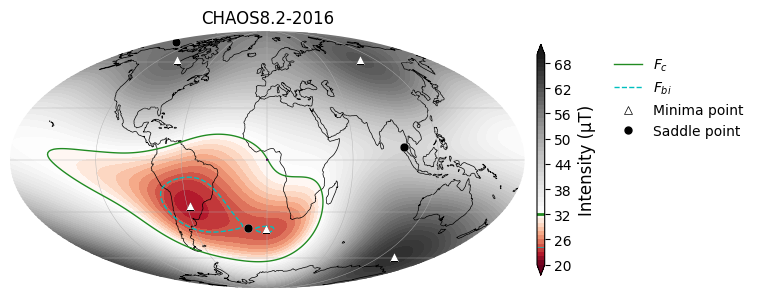

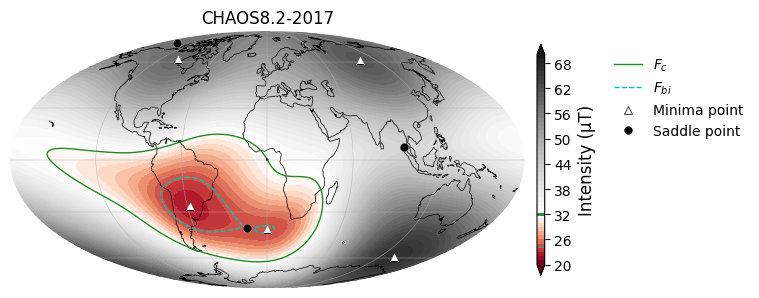

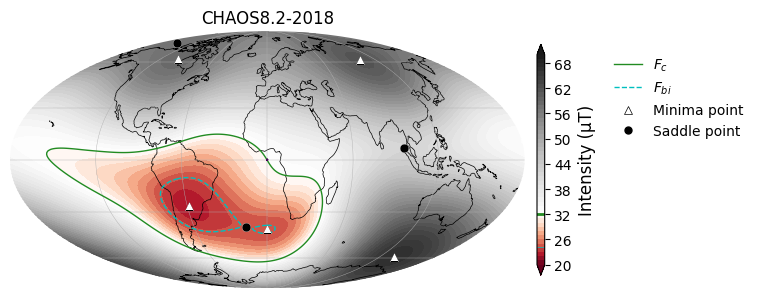

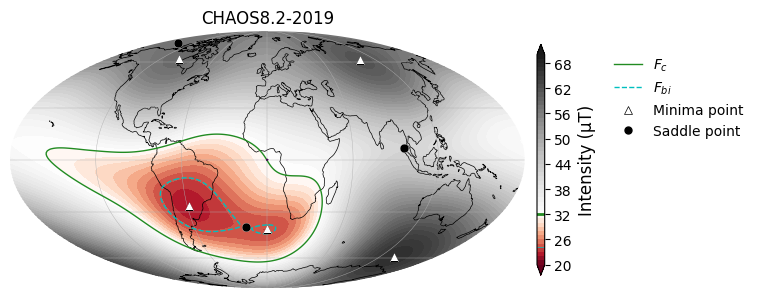

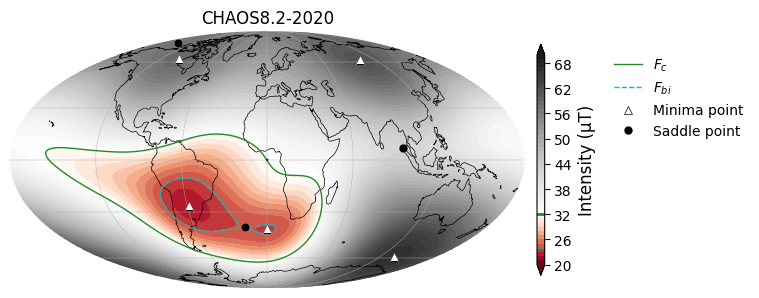

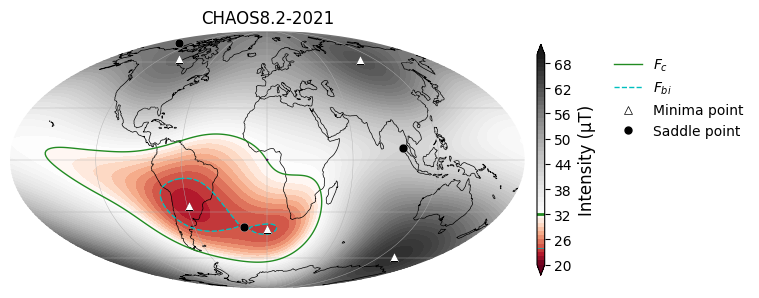

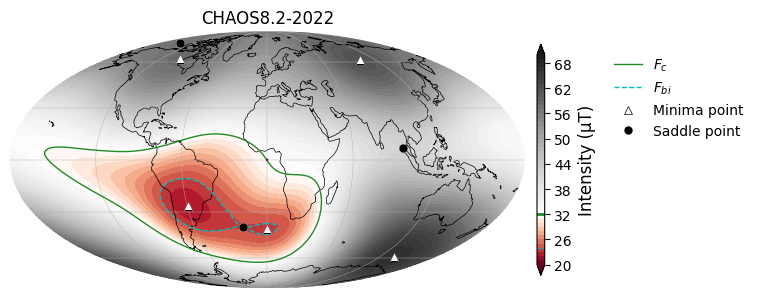

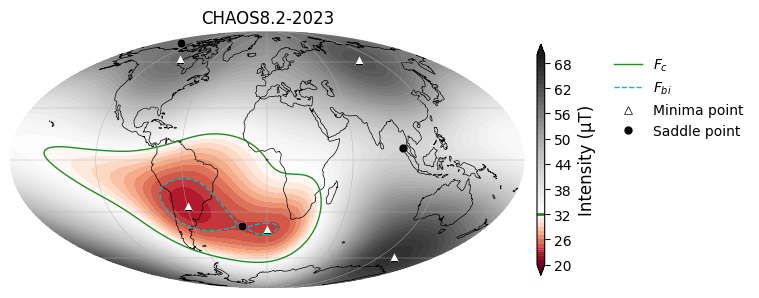

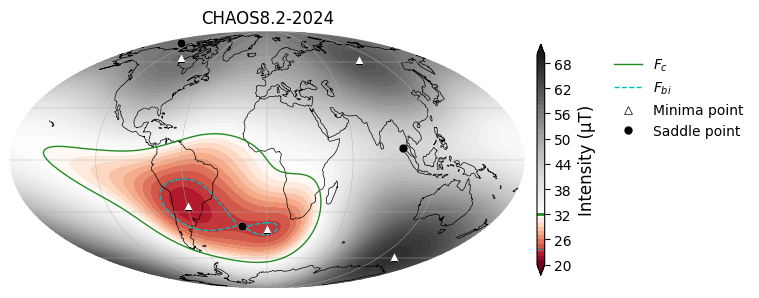

In [25]:
fontweight='bold'
fontname='Arial'
fontsize=14
markersize=40
linecolor = 'forestgreen'
camp="RdGy"
markersize = 40
SaddleColor="k"
SaddleMarker="o"
ExtremaColor="white"
ExtremaMarker="^"
linecolor='forestgreen'
vmin = 20
vmax = 70
r=6371
for yr in range(2000,2025, 1):
    time = cp.data_utils.mjd2000(yr, 1, 1)  # modified Julian date
    B_radius, B_theta, B_phi = model.synth_values_tdep(time, radiusm, thetam, phim)
    F = np.sqrt(B_radius ** 2 + B_theta ** 2 + B_phi ** 2) / 1000
    Fout = calculate_integral(F)
    Fc = 32 * (Fout / Fo2020)
    vcenter = Fc  # 想让这个值为白色
    norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    
    F_real = F
    d_x = dx(thetam, phim, F_real)
    d_y = dy(thetam, phim, F_real)
    dd_x = ddx(thetam, phim, F_real)
    dd_y = ddy(thetam, phim, F_real)
    dd_xy = ddxy(thetam, phim, F_real)
    DETH = detH(dd_x, dd_y, dd_xy)
    crossingsX1, crossingsY1= F_C_ObO(phi, theta, d_x, d_y,0)
    E, S = detH_saddle(DETH, thetam, phim, crossingsX1, crossingsY1)
    
    H_S_lat, H_S_lon=S[:,0],S[:,1]
    H_E_lat, H_E_lon=E[:,0],E[:,1]
    print(len(crossingsX1))

    br,bt,bp=model.synth_values_tdep(time, r, H_S_lat, H_S_lon)
    F_S=np.sqrt(br ** 2 +bt ** 2 + bp ** 2) / 1000
    
    br,bt,bp=model.synth_values_tdep(time, r, H_E_lat, H_E_lon)
    F_E=np.sqrt(br ** 2 +bt ** 2 + bp ** 2) / 1000
    F_S = np.array(F_S)
    F_E = np.array(F_E)
    mask_S = F_S < Fc
    mask_E = F_E < Fc
    F_S = np.array(F_S)
    F_E = np.array(F_E)
    mask_S = F_S < Fc
    mask_E = F_E < Fc
    
    # 筛选出符合条件的点及坐标
    F_S_selected = F_S[mask_S]
    F_E_selected = F_E[mask_E]
    
    lat_S_selected = H_S_lat[mask_S]
    lon_S_selected = H_S_lon[mask_S]
    
    lat_E_selected = H_E_lat[mask_E]
    lon_E_selected = H_E_lon[mask_E]
    # RdGy

    
    F_S_selected=np.array(F_S_selected)
    
    fig = plt.figure(figsize=(8, 6))
    ax1 = plt.subplot(1, 1, 1,projection=ccrs.Mollweide())
    # ax1.set_global()
    ax1.coastlines(linewidth=0.5)
    ax1.gridlines(draw_labels=False, linewidth=0.3)
    for spine in ax1.spines.values():
        spine.set_visible(False)
        
    C = np.linspace(20., 70., 51)
    c1 = ax1.contourf(phim,90- thetam, F , levels=C, cmap=camp, transform=ccrs.PlateCarree(),extend="both",norm=norm )
    c2 = ax1.contour(phim, 90-thetam, F, levels=[Fc], colors=linecolor,linewidths=1, transform=ccrs.PlateCarree())
    
    ax1.scatter(H_E_lon, 90 - H_E_lat, color=ExtremaColor, marker=ExtremaMarker, s=markersize, transform=ccrs.PlateCarree(), zorder=5,edgecolors="k",linewidths=0.1)
    ax1.scatter(H_S_lon, 90 - H_S_lat, color=SaddleColor, marker=SaddleMarker,s=markersize, transform=ccrs.PlateCarree(), zorder=5,edgecolors="white",linewidths=0.2)
    
    
    

    if len(F_S_selected)>0:
        for i in range(0,len(F_S_selected)):
            c2 = ax1.contour(phim, 90-thetam,F, levels=[0.999*F_S_selected[i]], colors='c',linewidths=1, transform=ccrs.PlateCarree(),linestyles='--')
        
    
    legend_elements1 = [
        Line2D([0], [0], color=linecolor, lw=1 , label=r'$F_c$'),
        Line2D([0], [0], color='c', lw=1 , label=r'$F_{bi}$',linestyle='dashed'),
        Line2D([0], [0], color=ExtremaColor, marker=ExtremaMarker,label='Minima point', markersize=6, linestyle='None', markeredgecolor='k',markeredgewidth=0.5),
        Line2D([0], [0], marker=SaddleMarker, color=SaddleColor, label='Saddle point', markersize=5, linestyle='None'),
         # Line2D([0], [0], marker=massmarker, color=masscolor, label='Center of mass in $F_c$', markersize=5, linestyle='None'),
        # Line2D([0], [0], color='c', lw=1 , label=r'$F_{bi}$',linestyle='dashed'),
        # Line2D([0], [0], color='plum', lw=1 , label=r'$F_{saddle~2}$',linestyle='dashed')
    ]
    ax1.legend(
        handles=legend_elements1,
        loc='upper left',              # 图例“对齐方式”
        bbox_to_anchor=(1.15, 0.95),     # 图外右上角，x=1.2表示往右移动，y=1.0表示顶部对齐
        frameon=False)
    # ax1.legend(handles=legend_elements1, loc='best')
    cbar = fig.colorbar(c1, ax=ax1, orientation='vertical', pad=0.02, aspect=30,shrink=0.5)
    cbar.set_label("Intensity (μT)", fontsize=12)
    cbar.ax.axhline(Fc, color=linecolor, linewidth=2)
    if len(F_S_selected)>0:
        for i, val in enumerate(F_S_selected):
            cbar.ax.axhline(val * 0.999,  color='c',linewidth=0.5)
    ax1.set_title(f"CHAOS8.2-{yr}")
    plt.savefig("D:\Fig\Chaos\{}.png".format(yr), dpi=300, bbox_inches='tight')
    print("yr=", yr)



In [24]:

br,bt,bp=model.synth_values_tdep(time, r, H_S_lat, H_S_lon)
F_S=np.sqrt(br ** 2 +bt ** 2 + bp ** 2) / 1000

br,bt,bp=model.synth_values_tdep(time, r, H_E_lat, H_E_lon)
F_E=np.sqrt(br ** 2 +bt ** 2 + bp ** 2) / 1000
F_S = np.array(F_S)
F_E = np.array(F_E)
mask_S = F_S < Fc
mask_E = F_E < Fc
r=6371

F_S,H_S_lat

(array([41.50994479, 56.97901084]), array([82.31117549, 11.88847798]))